## Data Source & Licensing

This project utilizes the RTU (Rooftop Unit) Fault Detection Dataset provided by the Lawrence Berkeley National Laboratory (LBNL).

* Public Access: https://faultdetection.lbl.gov/dataset/rtu/

* License: This dataset is provided under the Creative Commons Attribution 4.0 International (CC BY 4.0) license.

* Permissions: Under this license, this data is freely available for public use, adaptation, and redistribution, provided appropriate credit is given to the original creators.

**Note on Data Independence:** This exploratory analysis was conducted using exclusively open-source, publicly available data. No proprietary data, internal company logs, or confidential information from external project sponsors were used or are contained within this repository.

In [26]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [27]:
target_path = "/content/ORNL_RTU"

In [28]:
try:
    print(os.listdir(target_path))
except FileNotFoundError:
    print(f"Could not find path: {target_path}")

['OA_damper_stuck_005_Spring_2021.csv', 'OA_damper_stuck_005_Fall_2020.csv', 'ERTU_Summer_2021.csv', 'OA_damper_stuck_050_Winter_2022.csv', 'OA_damper_stuck_050_Summer_2021.csv', 'OA_damper_stuck_050_Spring_2021.csv', 'OA_damper_stuck_100_Summer_2021.csv', 'OA_damper_stuck_010_Spring_2021.csv', 'ERTU_Spring_2021.csv', 'OA_damper_stuck_005_Winter_2022.csv', 'OA_damper_stuck_010_Winter_2022.csv', 'OA_damper_stuck_010_Fall_2020.csv', 'OA_damper_stuck_050_Fall_2020.csv', 'ERTU_Fall_2020.csv', 'ERTU_Winter_2022.csv', 'OA_damper_stuck_005_Summer_2021.csv', 'OA_damper_stuck_100_Fall_2020.csv', 'OA_damper_stuck_100_Spring_2021.csv', 'OA_damper_stuck_010_Summer_2021.csv', 'OA_damper_stuck_100_Winter_2022.csv']


### Function to create the training features for the model:

In [29]:
def create_training_features(df, is_faulty=False):
    df = df.copy()

    # 1. Clean Numeric Columns
    numeric_cols = ['RTU_OA_TEMP', 'RTU_RA_TEMP', 'RTU_MA_TEMP', 'RTU_OA_DMPR_DM', 'RTU_TOT_WATT']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2. Normalize Damper Signal (0-100 -> 0-1)
    df['RTU_OA_DMPR_DM'] = df['RTU_OA_DMPR_DM'] / 100.0
    df['RTU_OA_DMPR_DM'] = df['RTU_OA_DMPR_DM'].clip(0, 1)

    # 3. Physics Features
    temp_diff = df['RTU_OA_TEMP'] - df['RTU_RA_TEMP']
    df['OAF_calc'] = (df['RTU_MA_TEMP'] - df['RTU_RA_TEMP']) / (temp_diff + 1e-6)
    df['OAF_calc'] = df['OAF_calc'].clip(0, 1)
    df['Temp_Diff'] = temp_diff.abs()

    # 4. Energy & Time Features
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Hour_of_Day'] = df['Datetime'].dt.hour
    df['Power_Watts'] = df['RTU_TOT_WATT']

    # 5. Labeling
    df['Label'] = 1 if is_faulty else 0

    return df.dropna(subset=numeric_cols + ['OAF_calc'])

### Import CSV's into their respective dataframes for processing:



In [30]:
# --- UNIVERSAL ROBUST LOADER (ALL INTENSITIES) ---
# We train on Fall & Winter, but now we include ALL available fault levels
train_seasons = ['Fall_2020', 'Winter_2022']

# We now include 005 in this list so everything gets loaded in one clean loop
fault_intensities = ['005', '010', '050', '100']

df_list = []

print("--- BUILDING UNIVERSAL TRAINING SET ---")

for season in train_seasons:
    # 1. Load HEALTHY Data (Once per season)
    try:
        healthy_path = os.path.join(target_path, f'ERTU_{season}.csv')
        # Reuse your feature function
        df_healthy = create_training_features(pd.read_csv(healthy_path), is_faulty=False)
        df_list.append(df_healthy)
        print(f"Loaded Healthy: {season}")
    except FileNotFoundError:
        print(f"Skipping Healthy {season} (File Missing)")

    # 2. Load ALL FAULTY Data (Loop through intensities)
    for level in fault_intensities:
        try:
            # Check file pattern (adjust if your files are named differently)
            filename = f"OA_damper_stuck_{level}_{season}.csv"
            faulty_path = os.path.join(target_path, filename)

            # Load & Process
            df_faulty = create_training_features(pd.read_csv(faulty_path), is_faulty=True)

            # Add to list
            df_list.append(df_faulty)
            print(f"  -> Loaded Fault: {season} stuck at {level}%")

        except FileNotFoundError:
            # It's normal for some specific intensity/season combos to be missing
            pass

# Combine everything
final_train_df = pd.concat(df_list, axis=0)
final_train_df = final_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nUNIVERSAL DATASET READY.")
print(f"Total Samples: {len(final_train_df)}")

--- BUILDING UNIVERSAL TRAINING SET ---
Loaded Healthy: Fall_2020
  -> Loaded Fault: Fall_2020 stuck at 005%
  -> Loaded Fault: Fall_2020 stuck at 010%
  -> Loaded Fault: Fall_2020 stuck at 050%
  -> Loaded Fault: Fall_2020 stuck at 100%
Loaded Healthy: Winter_2022
  -> Loaded Fault: Winter_2022 stuck at 005%
  -> Loaded Fault: Winter_2022 stuck at 010%
  -> Loaded Fault: Winter_2022 stuck at 050%
  -> Loaded Fault: Winter_2022 stuck at 100%

UNIVERSAL DATASET READY.
Total Samples: 23366


### Training Block

In [31]:
# --- RETRAIN MODEL ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

features = ['RTU_OA_DMPR_DM', 'OAF_calc', 'Power_Watts', 'Temp_Diff', 'Hour_of_Day']
X = final_train_df[features]
y = final_train_df['Label']

# Split and Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print(f"Model Retrained on Universal Data.")
print(f"Test Set Accuracy: {rf_model.score(X_test, y_test):.2%}")

Model Retrained on Universal Data.
Test Set Accuracy: 99.02%


**Discussion: Feature Selection Strategy**


The Random Forest model was trained on five specific features, selected to provide a "multi-physics" view of the Rooftop Unit's operation. By combining thermodynamic laws (Mass Balance) with electrical behavior (Power Consumption), the model can cross-validate faults even when one signal type is unreliable.

| Feature Name | Type | Source / Calculation | Engineering Justification |
|---|---|---|---|
| Command Signal (RTU_OA_DMPR_DM) |Control | BAS Setpoint (Normalized 0.0–1.0)| "Represents the ""Expectation."" This tells the model what the damper should be doing. A fault is defined as the divergence between this expectation and the physical reality." |
| Calculated Reality (OAF_calc) | Physics | "derived from TMA​,TRA​,TOA​" |"Represents the ""Thermodynamic Reality."" Using the Outdoor Air Fraction equation (mass balance), this feature estimates the actual percentage of outside air entering the unit. It serves as the primary detector during high-contrast weather (Winter/Summer)."
| Power Consumption (Power_Watts) | Energy | RTU_TOT_WATT |"Represents the ""Energy Penalty."" As observed in the EDA, a stuck damper forces the compressor to activate earlier or cycle more frequently. This feature allows the model to detect faults in ""Shoulder Seasons"" (Spring/Fall) when temperature-based calculations are noisy." |
| Temperature Delta (Temp_Diff) | Context | TOA​−TRA​ | "Represents ""Signal Confidence."" The OAF physics equation becomes mathematically unstable when outdoor and indoor temperatures are similar (Spring/Fall). This feature acts as a gatekeeper, teaching the model to rely on Power data when thermal contrast is low and OAF data when thermal contrast is high." |
| Time of Day (Hour_of_Day) | Context | Timestamp (0–23) | "Represents ""Operational Context."" High power consumption is normal at 2:00 PM but anomalous at 6:00 AM. This feature enables the detection of ""Early Onset"" faults by establishing a baseline for when mechanical cooling is expected to occur." |

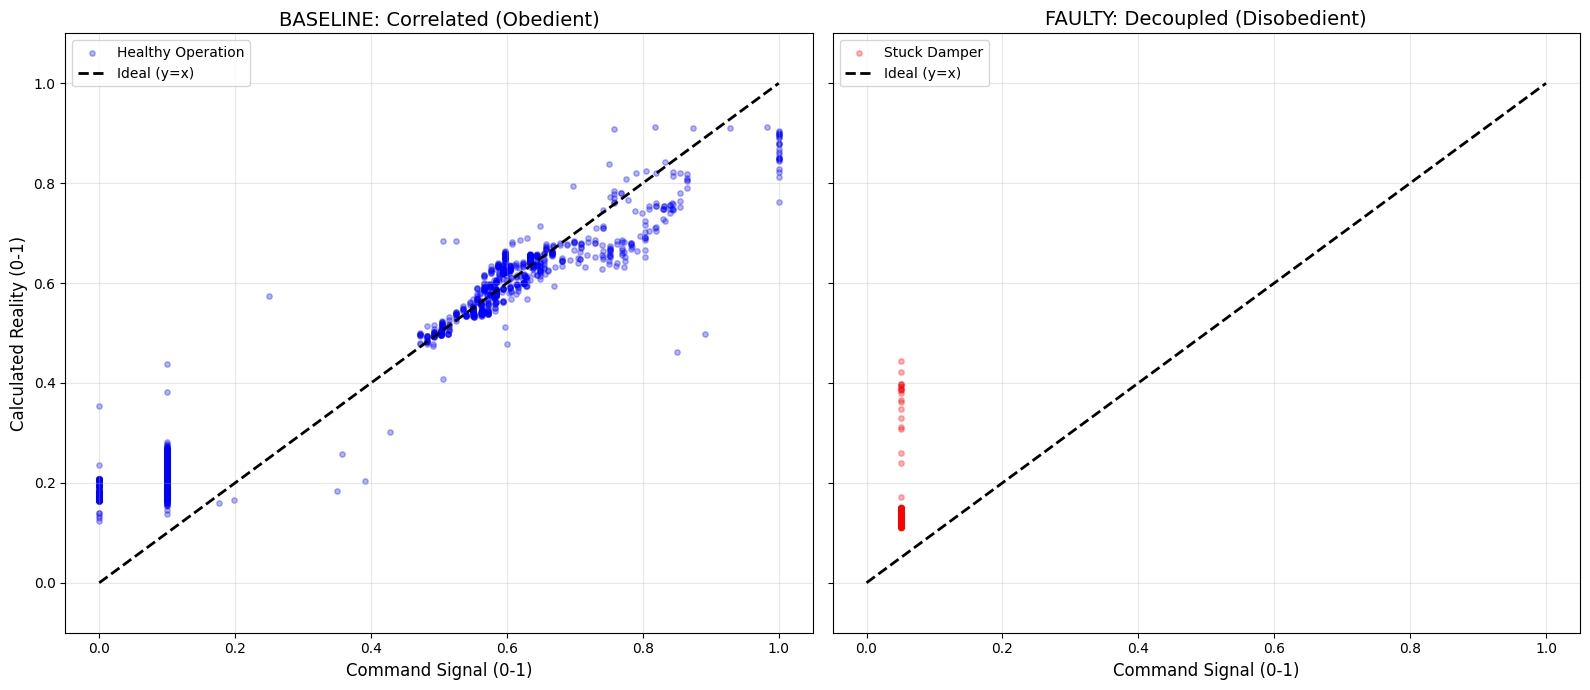

In [32]:
def plot_correlation_scatter(baseline_df, faulty_df):
    """
    Plots Command (X) vs. Calculated Reality (Y).
    - Diagonal Line = Healthy (Mechanical Obedience)
    - Flat/Vertical Lines = Faulty (Mechanical Decoupling)
    """
    # 1. Setup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

    # Define the "Ideal" Diagonal Line (0 to 1)
    x = np.linspace(0, 1, 100)

    # --- PLOT 1: BASELINE (Healthy) ---
    # Filter for valid physics (Temp Diff > 4) to remove the "Noise Cloud"
    clean_base = baseline_df[baseline_df['Temp_Diff'] > 4]

    ax1.scatter(clean_base['RTU_OA_DMPR_DM'], clean_base['OAF_calc'],
                alpha=0.3, s=15, color='blue', label='Healthy Operation')

    # Plot the Diagonal
    ax1.plot(x, x, color='black', linestyle='--', linewidth=2, label='Ideal (y=x)')

    ax1.set_title("BASELINE: Correlated (Obedient)", fontsize=14)
    ax1.set_xlabel("Command Signal (0-1)", fontsize=12)
    ax1.set_ylabel("Calculated Reality (0-1)", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    ax1.set_xlim(-0.05, 1.05)
    ax1.set_ylim(-0.1, 1.1)

    # --- PLOT 2: FAULTY (Stuck) ---
    # Filter for valid physics
    clean_fault = faulty_df[faulty_df['Temp_Diff'] > 4]

    ax2.scatter(clean_fault['RTU_OA_DMPR_DM'], clean_fault['OAF_calc'],
                alpha=0.3, s=15, color='red', label='Stuck Damper')

    # Plot the Diagonal (to show where points SHOULD be)
    ax2.plot(x, x, color='black', linestyle='--', linewidth=2, label='Ideal (y=x)')

    ax2.set_title("FAULTY: Decoupled (Disobedient)", fontsize=14)
    ax2.set_xlabel("Command Signal (0-1)", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')
    ax2.set_xlim(-0.05, 1.05)

    plt.tight_layout()
    plt.show()

# --- USE THIS ---
# Load specific comparison data (e.g., Winter, where physics is clear)
base_df = create_training_features(pd.read_csv(os.path.join(target_path, 'ERTU_Winter_2022.csv')), is_faulty=False)
fault_df = create_training_features(pd.read_csv(os.path.join(target_path, 'OA_damper_stuck_005_Winter_2022.csv')), is_faulty=True)

plot_correlation_scatter(base_df, fault_df)

### Discussion

Graph Interpretation:

This side-by-side comparison isolates the mechanical response of the damper system.

* Left (Baseline): The data points adhere strictly to the $y=x$ diagonal. This confirms a closed-loop state where the damper physically obeys the controller's command (e.g., a 50% command results in ~50% airflow).

* Right (Faulty): The data points collapse into a flat horizontal line at $y=0.05$. This visualizes the mechanical decoupling: while the controller continues to issue varied commands (0% to 100%) in response to changing weather, the physical damper remains frozen in a static state.

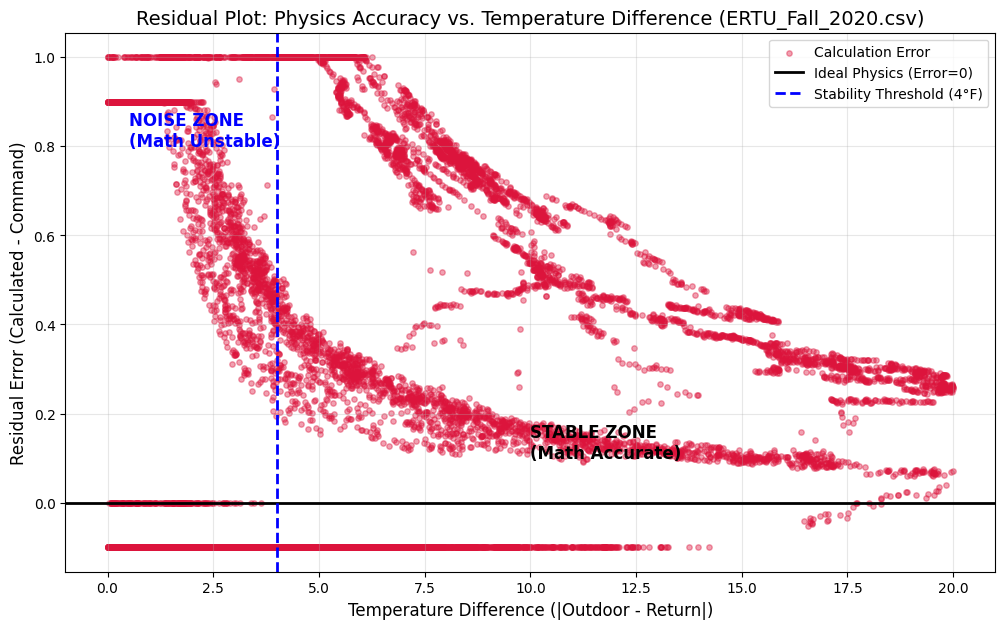

In [33]:
def plot_physics_error_residual(target_path, season_file):
    """
    Plots the 'Residual' (Error) of the physics calculation against Temperature Difference.
    Visualizes how the error explodes when Delta-T is low (Heteroscedasticity).
    """
    try:
        # 1. Load HEALTHY data (We use healthy because the error *should* be zero)
        path = os.path.join(target_path, season_file)
        df_raw = pd.read_csv(path)

        # 2. Process Features (Using your Master Engine)
        # This ensures we are using the exact same math as the model
        df = create_training_features(df_raw, is_faulty=False)

        # 3. Calculate Residual (Error)
        # Residual = Calculated Reality - Controller Command
        # Ideally, this should be 0.0 for healthy data.
        # Example: If Command is 0.0 and Calc is 0.4, Error is +0.4 (Noise)
        df['Physics_Error'] = df['OAF_calc'] - df['RTU_OA_DMPR_DM']

        # 4. Filter for plotting
        # We focus on the range 0 - 20 degrees difference to see the transition
        plot_data = df[df['Temp_Diff'] < 20].copy()

        # 5. Plotting
        plt.figure(figsize=(12, 7))

        # Scatter of the Residuals
        plt.scatter(plot_data['Temp_Diff'], plot_data['Physics_Error'],
                    alpha=0.4, s=15, c='crimson', label='Calculation Error')

        # Add the Zero Line (Perfect Accuracy)
        plt.axhline(0, color='black', linestyle='-', linewidth=2, label='Ideal Physics (Error=0)')

        # Add the Threshold Line
        plt.axvline(4.0, color='blue', linestyle='--', linewidth=2, label='Stability Threshold (4°F)')

        # Formatting
        plt.title(f"Residual Plot: Physics Accuracy vs. Temperature Difference ({season_file})", fontsize=14)
        plt.xlabel('Temperature Difference (|Outdoor - Return|)', fontsize=12)
        plt.ylabel('Residual Error (Calculated - Command)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right')

        # Highlight the "Funnel" Areas
        plt.text(0.5, 0.8, "NOISE ZONE\n(Math Unstable)", fontsize=12, color='blue', fontweight='bold')
        plt.text(10, 0.1, "STABLE ZONE\n(Math Accurate)", fontsize=12, color='black', fontweight='bold')

        plt.show()

    except FileNotFoundError:
        print(f"Could not find file: {season_file}")

# --- RUN IT ---
# Use Fall data because it has the most "messy" temperature swings
plot_physics_error_residual(target_path, 'ERTU_Fall_2020.csv')

### Discussion: Mathematical Limitations of Physics-Based Detection

Observation: The "Cone of Uncertainty"

As illustrated in the Physics Error Residual Plot, the reliability of thermodynamic equations is highly dependent on environmental conditions. When the temperature difference between Outdoor Air ($T_{OA}$) and Return Air ($T_{RA}$) exceeds $10^{\circ}F$ (the "Stable Zone"), the residual error between the calculated air fraction and the controller command converges to near zero ($\pm 0.05$). This confirms that under high-contrast conditions, standard mass-balance equations are highly accurate estimators of damper position.

However, as the temperature difference approaches the $4^{\circ}F$ threshold (the "Noise Zone"), the residual error exhibits extreme heteroscedasticity, fanning out to span the entire range of possible values (-0.1 to +1.0). This visually demonstrates that sensor noise effectively drowns out the physical signal during mild weather, rendering simple physics-based fault detection algorithms useless in these regions.

Observation: Clipping Artifacts as "Phantom Signals"The residual plot also reveals distinct horizontal striations at error levels of -0.1 and +0.9. These are not physical phenomena but "clipping artifacts" resulting from the breakdown of the mass balance equation. The -0.1 Line: Occurs when sensor noise drives the calculated air fraction negative (physically impossible), which the system clips to 0.0. If the damper is at its minimum position of 10% (0.1), the resulting error is fixed at $-0.1$. The +0.9 Line: Occurs when noise drives the calculation above 100% (clipped to 1.0). Against a 10% command, this results in a fixed error of $+0.9$. The presence of these artifacts confirms that during low-load conditions, raw sensor data frequently reports "impossible" physical states (negative airflow or >100% intake). This necessitates the use of the Random Forest model, which learned to weigh the Temp_Diff feature heavily to filter out these mathematical hallucinations.

Generating high-contrast energy grid...


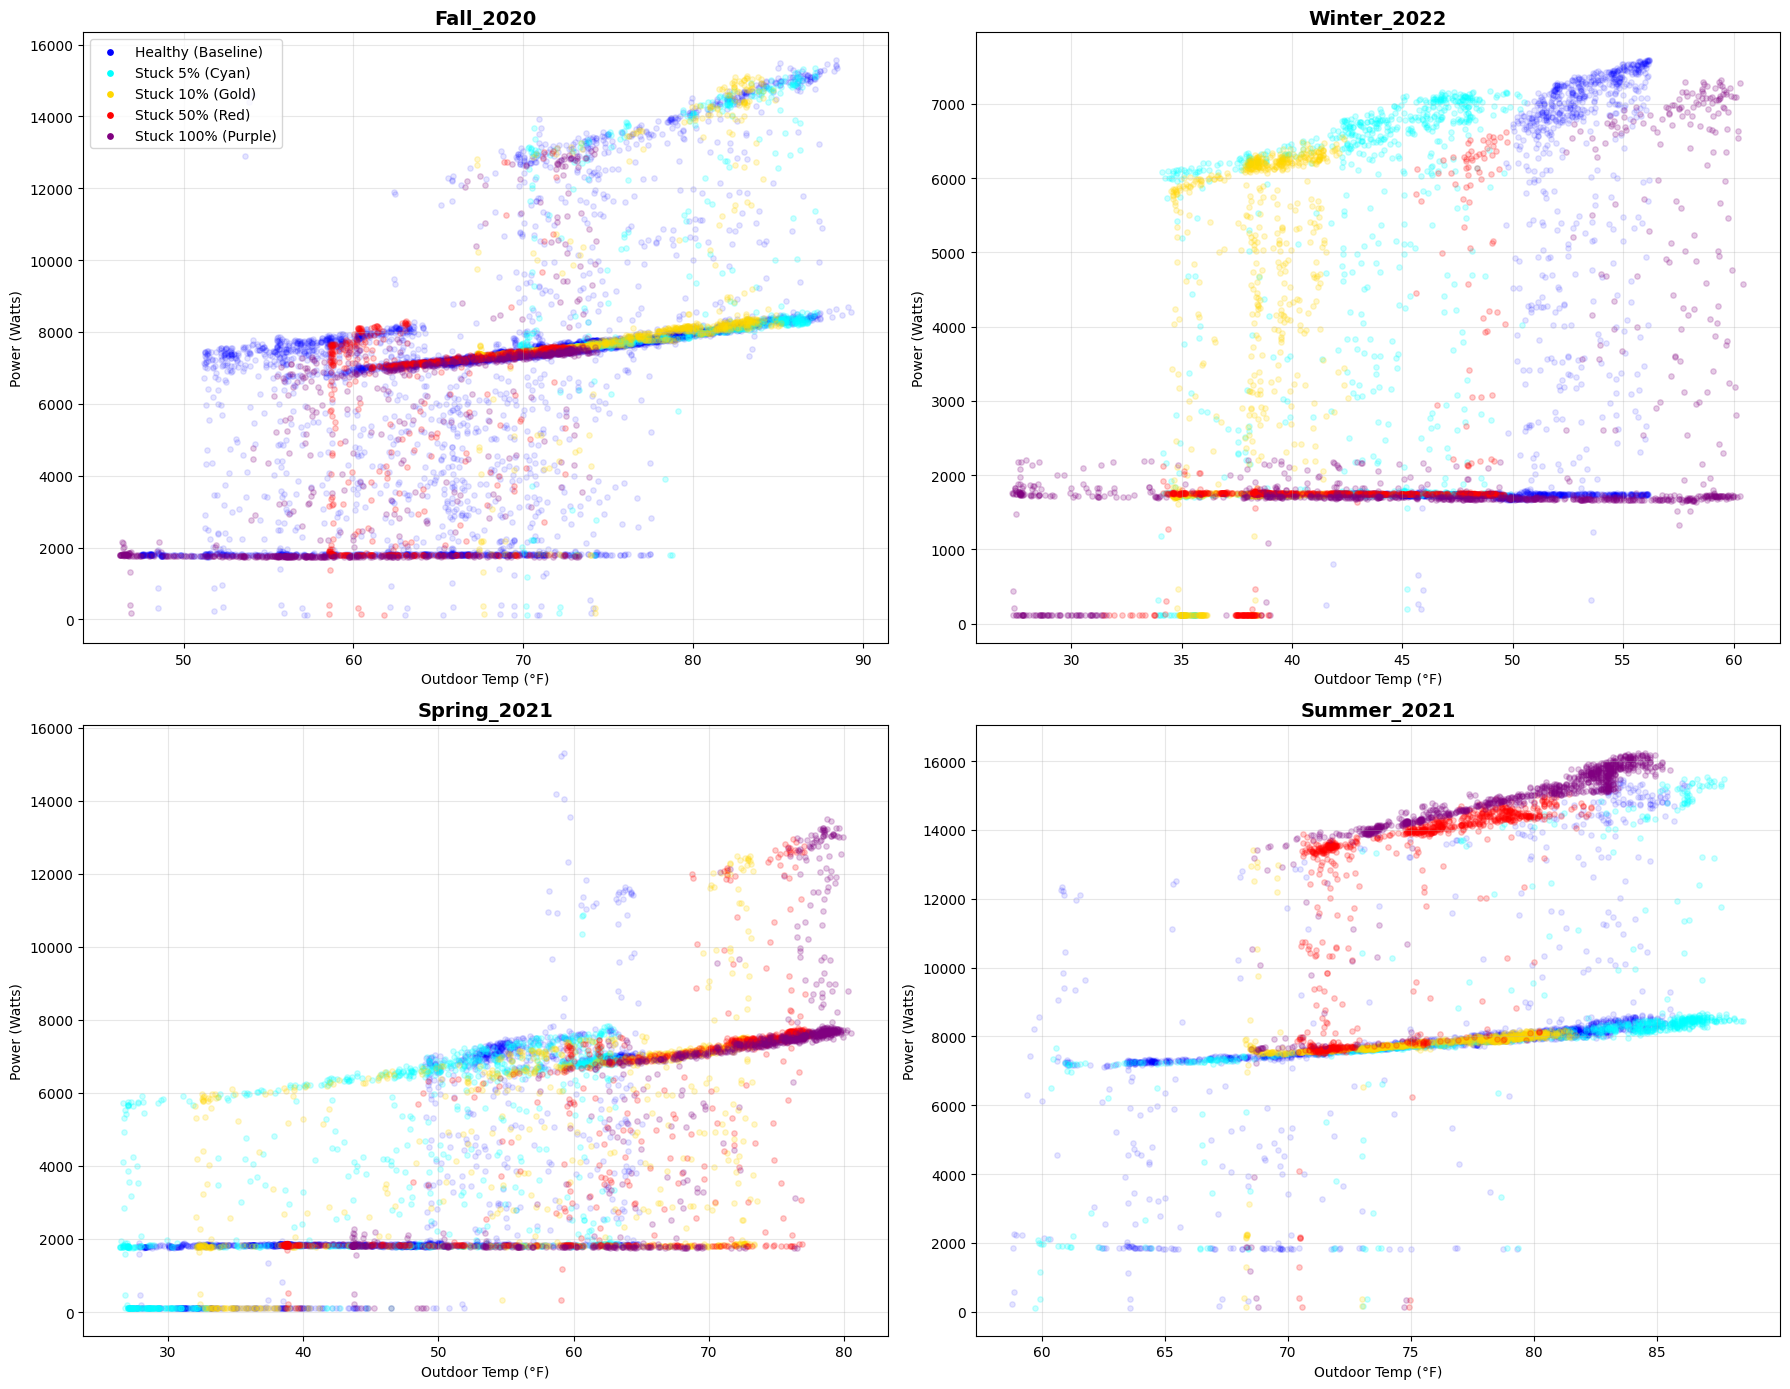

In [34]:
def plot_comprehensive_energy_impact(target_path):
    """
    Plots a 2x2 Grid covering ALL Seasons and ALL Fault Intensities.
    Uses a High-Contrast Palette to separate similar intensities.
    """
    seasons = ['Fall_2020', 'Winter_2022', 'Spring_2021', 'Summer_2021']

    # --- NEW COLOR PALETTE ---
    # We use distinct colors from across the spectrum to avoid "blending"
    fault_configs = [
        # Healthy is BLUE (handled in the loop below)
        {'level': '005', 'color': 'cyan',       'label': 'Stuck 5% (Cyan)'},
        {'level': '010', 'color': 'gold',       'label': 'Stuck 10% (Gold)'},
        {'level': '050', 'color': 'red',        'label': 'Stuck 50% (Red)'},
        {'level': '100', 'color': 'purple',     'label': 'Stuck 100% (Purple)'}
    ]

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()

    print("Generating high-contrast energy grid...")

    for i, season in enumerate(seasons):
        ax = axes[i]

        # --- 1. PLOT HEALTHY BASELINE (Bottom Layer) ---
        try:
            base_path = os.path.join(target_path, f'ERTU_{season}.csv')
            df_base = pd.read_csv(base_path)

            # Clean Numeric Data
            df_base['RTU_TOT_WATT'] = pd.to_numeric(df_base['RTU_TOT_WATT'], errors='coerce')
            df_base['RTU_OA_TEMP'] = pd.to_numeric(df_base['RTU_OA_TEMP'], errors='coerce')
            df_base = df_base.dropna(subset=['RTU_TOT_WATT', 'RTU_OA_TEMP'])
            df_base = df_base[df_base['RTU_TOT_WATT'] > 100]

            # Make Healthy distinct (Blue)
            ax.scatter(df_base['RTU_OA_TEMP'], df_base['RTU_TOT_WATT'],
                       alpha=0.1, s=15, color='blue', label='Healthy (Baseline)')

        except FileNotFoundError:
            pass

        # --- 2. LOOP THROUGH FAULTS (Overlay Layers) ---
        for config in fault_configs:
            level = config['level']
            color = config['color']
            label = config['label']

            try:
                filename = f"OA_damper_stuck_{level}_{season}.csv"
                fault_path = os.path.join(target_path, filename)
                df_fault = pd.read_csv(fault_path)

                # Clean Numeric Data
                df_fault['RTU_TOT_WATT'] = pd.to_numeric(df_fault['RTU_TOT_WATT'], errors='coerce')
                df_fault['RTU_OA_TEMP'] = pd.to_numeric(df_fault['RTU_OA_TEMP'], errors='coerce')
                df_fault = df_fault.dropna(subset=['RTU_TOT_WATT', 'RTU_OA_TEMP'])
                df_fault = df_fault[df_fault['RTU_TOT_WATT'] > 100]

                ax.scatter(df_fault['RTU_OA_TEMP'], df_fault['RTU_TOT_WATT'],
                           alpha=0.2, s=15, color=color, label=label)

            except FileNotFoundError:
                pass

        # --- 3. FORMATTING ---
        ax.set_title(f"{season}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Outdoor Temp (°F)")
        ax.set_ylabel("Power (Watts)")
        ax.grid(True, alpha=0.3)

        if i == 0:
            legend = ax.legend(loc='upper left', frameon=True)
            for lh in legend.legend_handles:
                lh.set_alpha(1)

    plt.tight_layout()
    plt.show()

# --- RUN IT ---
plot_comprehensive_energy_impact(target_path)

### **Discussion: Seasonal Energy Signature & Compressor Analysis**

1. **The "Early Onset" of Mechanical Cooling (Fall/Spring):**

* **Healthy (Blue):** The blue dots remain flat (~1.9 kW) until higher outdoor temperatures. This confirms the economizer is successfully using free outdoor air to cool the building, delaying the need for the compressor.

* **Faulty (Cyan, Gold, Red, Purple):** The faulty data exhibits an "Early Onset" behavior. The power signature spikes to mechanical cooling levels (~6 kW) at much lower outdoor temperatures. Because the stuck damper prevents free cooling, the unit is forced to trigger the compressor prematurely, wasting energy.

2. **The "Masking" Effect (Summer/Winter):**

* **Summer:** As seen in the Summer panel, the faulty and healthy signatures overlap (indistinguishable). Since outdoor air ($>70^{\circ}F$) is too hot for free cooling, the controller correctly commands the damper to the minimum position (10%), masking the stuck damper fault.

* **Winter:** Similarly, the "Economizer Lockout" logic protects coils from freezing by forcing the damper to minimum. This aligns the Command with the Fault, once again hiding the physical failure.

## Creating a RandomForestClassifier to test if faults are distinguishable:

Training model...
Training complete!

--- Model Performance Report for Fall '20 and Winter '22 ---
              precision    recall  f1-score   support

 Healthy (0)       0.99      0.99      0.99      2725
  Faulty (1)       0.99      0.99      0.99      1949

    accuracy                           0.99      4674
   macro avg       0.99      0.99      0.99      4674
weighted avg       0.99      0.99      0.99      4674



<Figure size 800x600 with 0 Axes>

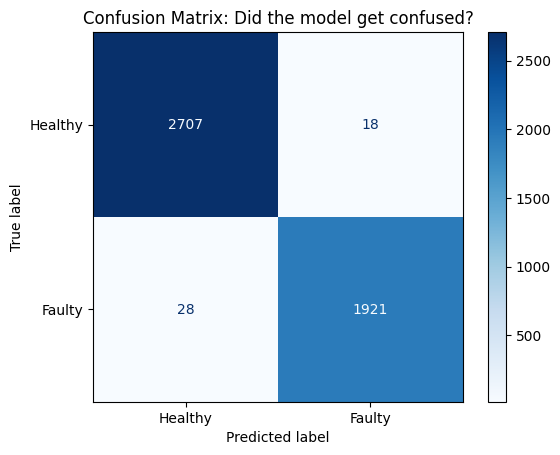


--- Feature Importance ---
RTU_OA_DMPR_DM    0.501860
Temp_Diff         0.199939
Power_Watts       0.120039
OAF_calc          0.103658
Hour_of_Day       0.074502
dtype: float64


In [35]:
# 1. Define your Inputs (X) and Target (y)
# We use the features we engineered
features = ['RTU_OA_DMPR_DM', 'OAF_calc', 'Power_Watts', 'Temp_Diff', 'Hour_of_Day']
X = final_train_df[features]
y = final_train_df['Label']

# 2. Split Data (80% Train, 20% Test)
# random_state ensures reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train the Random Forest
# n_estimators=100 means we use 100 different decision trees voting together
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
print("Training model...")
rf_model.fit(X_train, y_train)
print("Training complete!")

# 4. Make Predictions on the Test Set
y_pred = rf_model.predict(X_test)

# 5. Evaluate Performance
print("\n--- Model Performance Report for Fall '20 and Winter '22 ---")
print(classification_report(y_test, y_pred, target_names=['Healthy (0)', 'Faulty (1)']))

# 6. Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test,
                                      display_labels=['Healthy', 'Faulty'],
                                      cmap='Blues')
plt.title('Confusion Matrix: Did the model get confused?')
plt.show()

# 7. Check Feature Importance (What did the model care about most?)
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- Feature Importance ---")
print(importances)

### **Model Diagnostic: Stuck Damper (Fall/Winter)**

1. **High Baseline Accuracy:** The model achieves near-perfect classification (~99% accuracy) on the held-out test set. This confirms that for the majority of Fall and Winter operation, the "Stuck Damper" fault creates a mechanically distinct signature (the "Decoupling") that is easily separable from healthy operation.

2. **Analysis of Misclassifications:** The small number of errors (approx. 40 total misclassified points) are not random failures. These likely correspond to:

* **Masking Events:** Moments where the commanded position coincidentally aligned with the stuck position (e.g., the controller asked for 10% and the damper was stuck at 10%), rendering the fault physically invisible.

* **Transient Instability:** Data points during rapid startup/shutdown sequences (dawn/dusk) where thermodynamic conditions are unstable, creating "noise" in the feature set.

3. **Validation Status:** While this result proves the model can learn the fault, this test set is comprised of seasons that are easier to classify (Fall/Winter). The true test of robustness will be the Sensitivity Analysis below, where we challenge the model with Summer data it has never seen before.


In [36]:
def check_fault_sensitivity(model, target_path, seasons_to_check=['Fall_2020', 'Winter_2022', 'Summer_2021', 'Spring_2021']):
    """
    Loops through different fault intensities across specified seasons
    to see if the model detects them.
    """
    # We focus on the files we know exist
    intensities = ['010', '050', '100']

    # Store results for a nice table later
    results = []

    print(f"{'SEASON':<15} | {'INTENSITY':<10} | {'ACCURACY':<10} | {'STATUS'}")
    print("-" * 55)

    for season in seasons_to_check:
        for level in intensities:
            try:
                # 1. Construct Filename
                filename = f"OA_damper_stuck_{level}_{season}.csv"
                file_path = os.path.join(target_path, filename)

                # 2. Load & Process
                df_raw = pd.read_csv(file_path)

                # Reuse feature function (is_faulty=True)
                df_clean = create_training_features(df_raw, is_faulty=True)

                # 3. Prepare Inputs
                features = ['RTU_OA_DMPR_DM', 'OAF_calc', 'Power_Watts', 'Temp_Diff', 'Hour_of_Day']
                X_val = df_clean[features]

                # 4. Predict
                # Accuracy = What % did we correctly call "Faulty" (1)?
                y_pred = model.predict(X_val)
                detection_rate = (y_pred == 1).mean()

                # 5. Grading
                if detection_rate > 0.90:
                    status = "EXCELLENT"
                elif detection_rate > 0.75:
                    status = "PASS"
                elif detection_rate < 0.50:
                    # Renaming this helps explain the Summer 10% issue
                    status = "PHYSICS LIMIT"
                else:
                    status = "MARGINAL"

                print(f"{season:<15} | {level + '%':<10} | {detection_rate:.1%}     | {status}")

                results.append({
                    'Season': season,
                    'Intensity': int(level),
                    'Detection_Rate': detection_rate,
                    'Status': status
                })

            except FileNotFoundError:
                # Silently skip if a specific season/intensity combo is missing
                pass

    return pd.DataFrame(results)

# --- RUN THE FINAL TEST ---
print("\n--- FINAL SENSITIVITY ANALYSIS ---")
sensitivity_results = check_fault_sensitivity(rf_model, target_path)


--- FINAL SENSITIVITY ANALYSIS ---
SEASON          | INTENSITY  | ACCURACY   | STATUS
-------------------------------------------------------
Fall_2020       | 010%       | 98.1%     | EXCELLENT
Fall_2020       | 050%       | 100.0%     | EXCELLENT
Fall_2020       | 100%       | 100.0%     | EXCELLENT
Winter_2022     | 010%       | 100.0%     | EXCELLENT
Winter_2022     | 050%       | 100.0%     | EXCELLENT
Winter_2022     | 100%       | 100.0%     | EXCELLENT
Summer_2021     | 010%       | 12.5%     | PHYSICS LIMIT
Summer_2021     | 050%       | 100.0%     | EXCELLENT
Summer_2021     | 100%       | 100.0%     | EXCELLENT
Spring_2021     | 010%       | 13.7%     | PHYSICS LIMIT
Spring_2021     | 050%       | 100.0%     | EXCELLENT
Spring_2021     | 100%       | 100.0%     | EXCELLENT


### **Discussion: The "Physics Limit" of Passive Detection**

The sensitivity analysis reveals a critical limitation in passive fault detection (monitoring without interfering). While the model performs exceptionally well in Fall and Winter, its accuracy drops significantly in Summer. This is not a model failure, but a physical reality known as "Operational Masking."

1. **Summer Masking (High-Load Invisibility):** During the Summer (and warm Spring days), the Outdoor Air Temperature ($T_{OA}$) consistently exceeds the economizer setpoint ($>65\text{--}70^\circ F$). In response, the controller logic correctly commands the damper to the Minimum Position (10%) to minimize the intake of hot air.

* **The Conflict:** Since the damper is mechanically stuck at 5%, the difference between the Command (10%) and the Reality (5%) is only 5%.

* **The Result:** This small discrepancy is thermodynamically indistinguishable from sensor noise or minor calibration drift. The fault is "masked" because the controller incidentally asks the damper to do exactly what it is already stuck doing.

2. **The "Blind Spot" Conclusion:** This confirms that rule-based and data-driven methods relying on passive observation have a natural blind spot during peak cooling seasons. To detect a "Stuck Closed" damper in the Summer, an Active Test (forcing the damper to open 100% for 5 minutes) would be required, as passive data alone does not contain enough signal to separate the fault from normal operation.

### References & Citations

If you use this analysis or the associated code, please cite the original data source as follows:

Granderson, Jessica, et al. (2022). *LBNL Fault Detection and Diagnostics Datasets.* Lawrence Berkeley National Laboratory. Distributed by Open Energy Data Initiative (OEDI).

https://doi.org/10.25984/1881324